In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from kneed import KneeLocator
from datetime import date

# Clustering Experiment

As a method of feature reduction, we are applying unsupervised clustering to a cleaned and scaled housing attribute dataset. For now, we are sticking with K-means method of clustering. We would like to try the k-medoids method for clustering, but we are currently running into memory issues.

### Next steps:
Running kmean with a k of 7 results in a silhouette_score of .222.

[X] Using k-means with a k of 7 (determined using the elbow graph), we will generate a new csv with a column indicating the cluster id of the parcel (residential property).

[X] Calculate silhouette_score and silhouette_samples to evaluate each cluster

### References:

https://scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.cluster.KMedoids.html

https://medium.com/analytics-vidhya/supernaive-k-medoids-clustering-31db7bfc5075

https://developers.google.com/machine-learning/clustering/interpret

In [2]:
parcel_df = pd.read_csv('house_attributes.csv', index_col=0)
parcel_df.head(3)

,CONDO HR,MULTI-FAMILY,ROW END,ROW INTERIOR,OLD STYLE,SEMI DETACHED,CONDO,BI-LEVEL,SPLIT LEVEL,COLONIAL,...,None,Part,Full,Slab/Piers,Crawl,STORIES,TOTALROOMS,BEDROOMS,FULLBATHS,HALFBATHS
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-1.264172,-2.140282,-1.237946,0.782665,-0.947308
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-1.264172,-2.140282,-2.394149,-0.763327,0.796003
70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-1.264172,-0.934785,-0.081743,0.782665,-0.947308


In [3]:
parcel_df.shape

(143665, 52)

In [4]:
def create_elbow_plot(cluster_range, inertia_values):
    # from allegheny_county_property_assessments_eda
    # Converting the results into a dataframe and plotting them
    NumClusters  =[*cluster_range]
    frame = pd.DataFrame({'Cluster': cluster_range, 'inertia_values':inertia_values})
    plt.figure(figsize=(12,6))
    plt.plot(frame['Cluster'], frame['inertia_values'], marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

    kneedle = KneeLocator(NumClusters, inertia_values, curve='convex', direction='decreasing')
    cluster_count = kneedle.elbow
    
    plt.vlines([cluster_count], ymin=min(inertia_values), ymax=max(inertia_values))
    plt.plot()
    plt.show()

In [5]:
# Output:
# tuple of cardinality and cluster assignments for each loop
def run_kmeans_clustering():
    inertias = []
    cluster_cardinalities = []
    cluster_centers = []
    cluster_assignments = []
    for cluster_number in range(2,20):
        kmeans = KMeans(init='k-means++', n_clusters=cluster_number)
        clusters = kmeans.fit_predict(parcel_df) 

        print("")
        print("K-means: ", kmeans)
        # Record the inertia value
        inertias.append(kmeans.inertia_)
        
        # Record cluster centers, create data frame
        cluster_centers.append(kmeans.cluster_centers_)     
        cluster_assignments.append(clusters)
        
        # Record number of assignments to each label
        cardinality = np.unique(cluster_assignments, return_counts=True)
        cluster_cardinality_df = pd.DataFrame(data={
            'labels': cardinality[0],
            'frequency': cardinality[1],
        })
        cluster_cardinalities.append(cluster_cardinality_df)
        
        print(cluster_cardinality_df)
    return (cluster_cardinalities, inertias, cluster_assignments)

In [6]:
kmeans_clustering_data = run_kmeans_clustering()


K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
   labels  frequency
0       0      44151
1       1      99514

K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
   labels  frequency
0       0      99606
1       1     148896
2       2      38828

K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
   labels  frequency
0       0     132030
1       1     197818
2       2      64009
3       3      37138

K-means:  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute

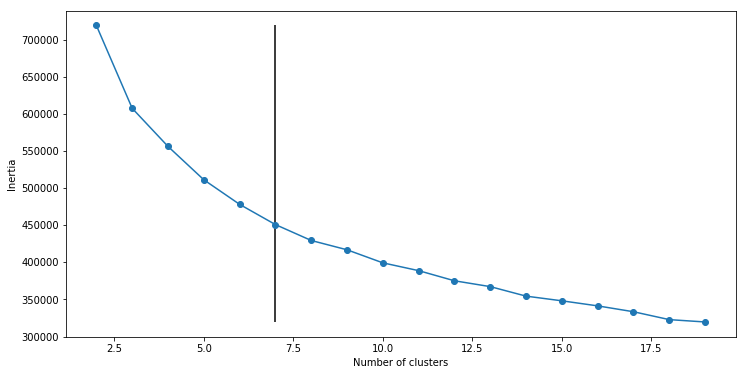

In [7]:
create_elbow_plot(range(2,20), kmeans_clustering_data[1])

In [8]:
k7means = KMeans(init='k-means++', n_clusters=7)
clusters_k7 = k7means.fit_predict(parcel_df)

In [9]:
clusters_k7

array([1, 1, 1, ..., 1, 0, 0], dtype=int32)

In [10]:
parcels_w_clusters = parcel_df.copy()
parcels_w_clusters['cluster_assignment'] = clusters_k7

### Silhouette Coefficient
<blockquote source='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score' >
    "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar."
    
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score
</blockquote>

In [12]:
average_silhouette_score = silhouette_score(parcel_df, clusters_k7) 
average_silhouette_score

0.22215500215130446

In [11]:
parcels_w_clusters.head(3)

,CONDO HR,MULTI-FAMILY,ROW END,ROW INTERIOR,OLD STYLE,SEMI DETACHED,CONDO,BI-LEVEL,SPLIT LEVEL,COLONIAL,...,Part,Full,Slab/Piers,Crawl,STORIES,TOTALROOMS,BEDROOMS,FULLBATHS,HALFBATHS,cluster_assignment
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.264172,-2.140282,-1.237946,0.782665,-0.947308,1
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.264172,-2.140282,-2.394149,-0.763327,0.796003,1
70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.264172,-0.934785,-0.081743,0.782665,-0.947308,1


In [23]:
parcels_w_clusters.shape

(143665, 53)

In [20]:
today = date.today().isoformat()
export_file_name = "cluster_assignment_for_parcels_{}.csv".format(today)
export_file_name = "cluster_assignment_for_parcels_{}".format(export_file_name)
parcels_w_clusters.to_csv(export_file_name)

In [ ]:
# look at cluster_magnitude

In [ ]:
# method for returning a parcel dataframe with the optimial cluster assignment and column for the centriod coords

In [ ]:
# def run_kmedoids_clustering():
#     print("run_kmedoids_clustering")
#     for cluster_number in range(2,20):
#         print("cluster number")
#         kmedoids = KMedoids(init='k-medoids++', n_clusters=cluster_number)
#         clusters = kmedoids.fit_predict(parcel_df) 
#         print('clusters')
#         pdb.set_trace()
#         print("")
#         print("K-medoids: ", kmedoids)
#         # Record the inertia value
#         inertias.append(kmedoids.inertia_float)
        
#         # Record cluster centers, create data frame
#         cluster_centers.append(kmedoids.cluster_centers_array)     
#         cluster_assignments.append(clusters)
        
#         # Record number of assignments to each label
#         cardinality = np.unique(cluster_assignments, return_counts=True)
#         cluster_cardinality_df = pd.DataFrame(data={
#             'labels': cardinality[0],
#             'frequency': cardinality[1],
#         })
#         cluster_cardinalities.append(cluster_cardinality_df)
        
#         print('')
#         print(cluster_cardinality_df)
#     return (cluster_cardinalities, inertias, cluster_assignments)

In [ ]:
# kmedoids_clustering_data = run_kmedoids_clustering()